# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  

In [10]:
import torchvision.datasets as datasets
from pathlib import Path
from collections import Counter
import torch
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader, random_split
import utils

In [11]:
DATA_DIR = Path("data")

imagenette_dataset = datasets.Imagenette(
    DATA_DIR, download=False
)


In [12]:
name_classes = imagenette_dataset.classes
nclasses = len(name_classes)

print(f"Clases: {name_classes}")

Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]


In [13]:
import matplotlib.pyplot as plt

# Contar la cantidad de imágenes por clase
labels = [imagenette_dataset.classes[target] for _, target in imagenette_dataset]
conteo = Counter(labels)


In [14]:
print(f'Cantidad de imágenes en el dataset: {len(labels)}')

Cantidad de imágenes en el dataset: 9469


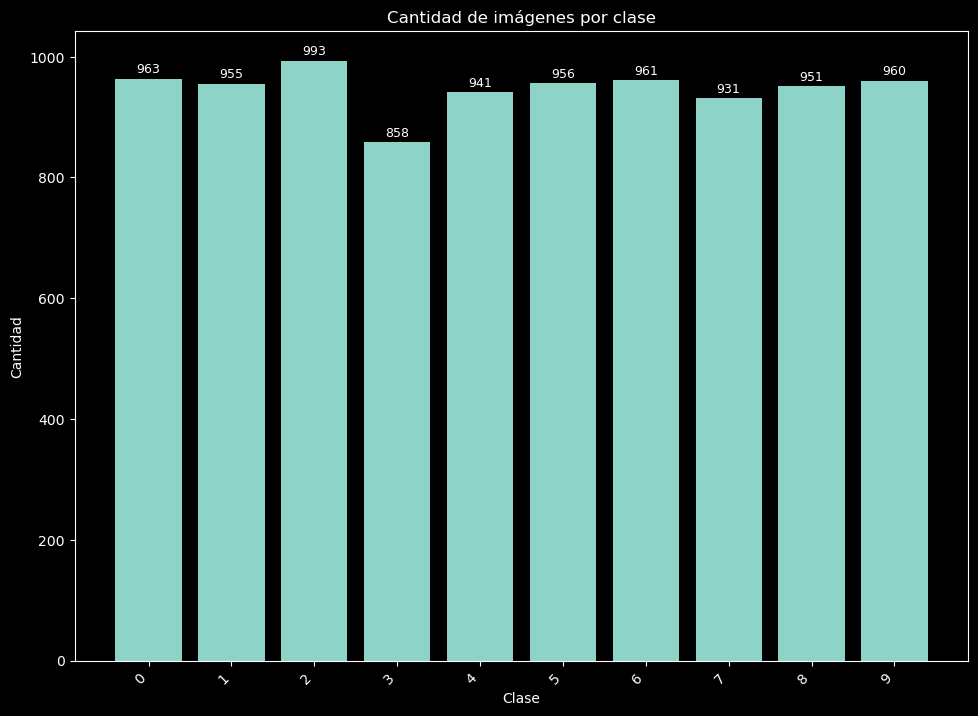

In [15]:
plt.figure(figsize=(10, 10))
plt.bar([", ".join(cls) for cls in conteo.keys()], conteo.values())
plt.xticks(rotation=45, ha='right')
plt.title("Cantidad de imágenes por clase")
plt.ylabel("Cantidad")
plt.xlabel("Clase")
plt.tight_layout()
for i, (k, v) in enumerate(zip(conteo.keys(), conteo.values())):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=9)
plt.xticks(ticks=range(len(conteo)), labels=range(len(conteo)), rotation=45, ha='right')
plt.show()

Si bien observamos que el dataset no contiene la misma cantidad exacta de imágenes por clase podríamos decir que el mismo esta balanceado.
La clase con más datos contiene el 10.5% del total mientras que la que tiene menos datos representa el 9.1%

In [16]:
sizes = [imagenette_dataset[i][0].size for i in range(len(imagenette_dataset))]
conteo_sizes = Counter(sizes)

In [17]:
sizes = [imagenette_dataset[i][0] for i in range(len(imagenette_dataset)) if imagenette_dataset[i][0].size == (149, 149)]

In [18]:
print(f"Cantidad de tamaños únicos: {len(conteo_sizes.keys())}")

Cantidad de tamaños únicos: 2296


In [19]:
conteo_sizes.most_common()

[((500, 375), 2174),
 ((500, 333), 818),
 ((375, 500), 717),
 ((333, 500), 309),
 ((500, 334), 207),
 ((640, 480), 126),
 ((500, 332), 91),
 ((500, 500), 88),
 ((400, 300), 78),
 ((500, 335), 75),
 ((334, 500), 67),
 ((500, 400), 53),
 ((500, 374), 46),
 ((332, 500), 45),
 ((200, 150), 44),
 ((500, 376), 42),
 ((335, 500), 38),
 ((600, 450), 36),
 ((500, 357), 34),
 ((500, 377), 33),
 ((240, 180), 31),
 ((1600, 1200), 31),
 ((400, 500), 30),
 ((250, 250), 27),
 ((1024, 768), 27),
 ((800, 600), 26),
 ((90, 90), 26),
 ((320, 240), 25),
 ((376, 500), 23),
 ((100, 100), 23),
 ((500, 281), 22),
 ((500, 338), 20),
 ((357, 500), 20),
 ((280, 280), 20),
 ((500, 337), 19),
 ((400, 400), 19),
 ((480, 360), 18),
 ((300, 225), 17),
 ((500, 331), 17),
 ((300, 300), 17),
 ((500, 340), 16),
 ((500, 341), 16),
 ((160, 160), 16),
 ((200, 200), 16),
 ((773, 1162), 16),
 ((1162, 773), 16),
 ((500, 348), 15),
 ((338, 500), 15),
 ((377, 500), 15),
 ((500, 350), 14),
 ((500, 381), 14),
 ((500, 395), 14),
 (

Aplicamos los transforms ToImage() para pasar las imágenes a tensores y Resize() para que todas las imágenes tengan el mismo tamaño (224,224)

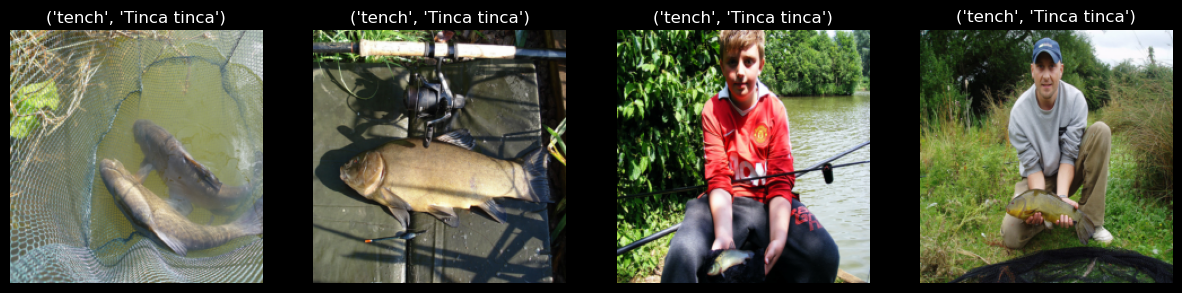

In [20]:
transforms = T.Compose([
    T.ToImage(),
    T.Resize((224, 224))

])

imagenette_dataset_transformado = datasets.Imagenette(
    DATA_DIR, download=False, transform=transforms
)

utils.show_tensor_images([imagenette_dataset_transformado[i][0] for i in range(4)], titles=[imagenette_dataset_transformado.classes[imagenette_dataset_transformado[i][1]] for i in range(4)])


In [21]:
sizes = [imagenette_dataset_transformado[i][0].size() for i in range(len(imagenette_dataset_transformado))]

In [22]:
conteo_sizes_2 = Counter(sizes)
conteo_sizes_2

Counter({torch.Size([3, 224, 224]): 9469})

Luego de aplicadas las transformaciones observamos que solamente tenemos tensores de 1 forma [3, 224, 224]. El 3 corresponde a la cantidad de canales por ser imágenes RGB. 
Aplicaremos la tranformacion Grayscale para pasar las imagenes a escala de grises

In [23]:
transforms = T.Compose([
    T.ToImage(),
    T.Grayscale(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((224, 224))

])

imagenette_dataset_train = datasets.Imagenette(
    DATA_DIR, download=False,split = 'train', transform=transforms
)

imagenette_dataset_val = datasets.Imagenette(
    DATA_DIR, download=False,split = 'val', transform=transforms
)

In [24]:
sizes_final = [imagenette_dataset_train[i][0].size() for i in range(len(imagenette_dataset_train))]   


In [25]:
conteo_sizes_final = Counter(sizes_final)
conteo_sizes_final

Counter({torch.Size([1, 224, 224]): 9469})

In [26]:
imagenette_dataset_train, imagenette_dataset_test = random_split(
    imagenette_dataset_train, [0.8, 0.2]
)

Entrenamiento

In [27]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [28]:
BATCH_SIZE = 128  # tamaño del batch

In [29]:
def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = DataLoader(
        imagenette_dataset_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = DataLoader(
        imagenette_dataset_val,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        imagenette_dataset_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = get_dataloaders()

### Red convolucional simple y loop de entrenamiento (prueba rápida)

In [30]:
# SimpleCNN: pequeña red convolucional para probar el pipeline
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class SimpleCNN(nn.Module):
    def __init__(self, input, n_classes):
        super().__init__()
        self.conv = nn.Sequential(
            #224*224
            nn.Conv2d(input[0], 16, kernel_size=8, padding=4, stride=2),
            nn.ReLU(inplace=True),
            #113*113
            nn.Conv2d(16, 32, kernel_size=5, stride=2),
            nn.ReLU(inplace=True)
            #55*55
            )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 55 * 55, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, n_classes),
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x



# Instanciar el modelo
model = SimpleCNN(train_loader.dataset[0][0].shape, nclasses).to(DEVICE)
print(model)

# Funciones de entrenamiento/validación rápidas (para prueba)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_errors, val_errors = utils.train(model, optimizer=optimizer, criterion=criterion, do_early_stopping=False,train_loader=train_loader, val_loader=val_loader, device=DEVICE, epochs=10)



SimpleCNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(8, 8), stride=(2, 2), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=96800, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)
Epoch: 001 | Train Loss: 2.17516 | Val Loss: 1.85670
Epoch: 002 | Train Loss: 1.71069 | Val Loss: 1.78135
Epoch: 003 | Train Loss: 1.40758 | Val Loss: 1.66579
Epoch: 004 | Train Loss: 1.01029 | Val Loss: 1.69583
Epoch: 005 | Train Loss: 0.56314 | Val Loss: 2.03264
Epoch: 006 | Train Loss: 0.24968 | Val Loss: 2.23720
Epoch: 007 | Train Loss: 0.09446 | Val Loss: 2.65802
Epoch: 008 | Train Loss: 0.03516 | Val Loss: 3.09899
Epoch: 009 | Train Loss: 0.02087 | Val Loss: 3.30312
Epoch: 010 | Train Loss: 0.02860 | Val Loss: 3.34299


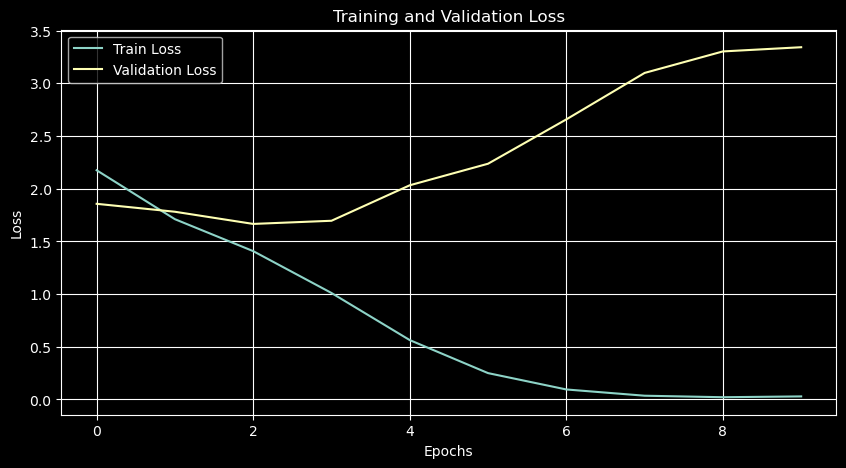

Accuracy: 0.4242

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.71      0.27      0.39       207
           1       0.47      0.49      0.48       189
           2       0.60      0.52      0.56       203
           3       0.35      0.14      0.20       189
           4       0.45      0.59      0.51       201
           5       0.43      0.21      0.28       174
           6       0.55      0.44      0.49       201
           7       0.27      0.49      0.35       163
           8       0.27      0.51      0.35       176
           9       0.49      0.57      0.53       190

    accuracy                           0.42      1893
   macro avg       0.46      0.42      0.41      1893
weighted avg       0.47      0.42      0.42      1893



In [38]:
utils.plot_taining(train_errors, val_errors)
utils.model_calassification_report(model, test_loader, DEVICE, nclasses)

In [39]:
class RegularizedCNN(nn.Module):
    def __init__(self, input, n_classes, dropout_rate=0.5):
        super().__init__()
        self.conv = nn.Sequential(
            #224*224
            nn.Conv2d(input[0], 16, kernel_size=8, padding=4, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            #113*113
            nn.Conv2d(16, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2)
            #55*55
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 55 * 55, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, n_classes),
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x

In [40]:
model_reg = RegularizedCNN(train_loader.dataset[0][0].shape, nclasses).to(DEVICE)
print(model_reg)

RegularizedCNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(8, 8), stride=(2, 2), padding=(4, 4))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout2d(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=96800, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [71]:
criterion_reg = nn.CrossEntropyLoss()
optimizer_reg = optim.Adam(model_reg.parameters(), lr=1e-3)

train_errors_reg, val_errors_reg = utils.train(
    model_reg, 
    optimizer=optimizer_reg, 
    criterion=criterion_reg, 
    do_early_stopping=True,
    patience=10,
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=DEVICE, 
    epochs=50
)

Epoch: 001 | Train Loss: 1.91380 | Val Loss: 2.00935
Epoch: 002 | Train Loss: 1.90457 | Val Loss: 1.98422
Epoch: 003 | Train Loss: 1.86773 | Val Loss: 1.98595
Epoch: 004 | Train Loss: 1.83028 | Val Loss: 1.94855
Epoch: 005 | Train Loss: 1.82907 | Val Loss: 2.03380
Epoch: 006 | Train Loss: 1.83062 | Val Loss: 1.96618
Epoch: 007 | Train Loss: 1.82024 | Val Loss: 1.98078
Epoch: 008 | Train Loss: 1.79216 | Val Loss: 2.02264
Epoch: 009 | Train Loss: 1.76247 | Val Loss: 1.98547
Epoch: 010 | Train Loss: 1.73774 | Val Loss: 2.00053
Epoch: 011 | Train Loss: 1.74784 | Val Loss: 2.01061
Epoch: 012 | Train Loss: 1.74934 | Val Loss: 2.04199
Epoch: 013 | Train Loss: 1.75015 | Val Loss: 2.00775
Epoch: 014 | Train Loss: 1.69310 | Val Loss: 1.98916
Detener entrenamiento en la época 13, la mejor pérdida fue 1.94855


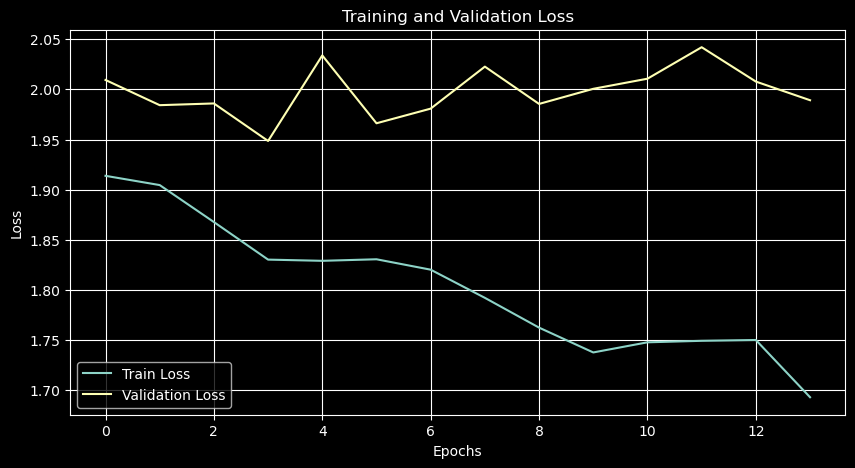

Accuracy: 0.3080

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.68      0.29      0.41       207
           1       0.35      0.48      0.41       189
           2       0.21      0.09      0.13       203
           3       0.17      0.09      0.12       189
           4       0.44      0.21      0.29       201
           5       0.21      0.33      0.26       174
           6       0.20      0.61      0.30       201
           7       0.09      0.02      0.04       163
           8       0.33      0.30      0.31       176
           9       0.68      0.61      0.64       190

    accuracy                           0.31      1893
   macro avg       0.34      0.30      0.29      1893
weighted avg       0.34      0.31      0.29      1893



In [72]:
utils.plot_taining(train_errors_reg, val_errors_reg)
utils.model_calassification_report(model_reg, test_loader, DEVICE, nclasses)

In [73]:
class ImprovedCNN(nn.Module):
    def __init__(self, input_shape, n_classes, dropout_rate=0.3):
        super().__init__()
        
        # Bloque convolucional 1: 224x224 -> 112x112
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=0.1)
        )
        
        # Bloque convolucional 2: 112x112 -> 56x56
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=0.2)
        )
        
        # Bloque convolucional 3: 56x56 -> 28x28
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=0.2)
        )
        
        # Bloque convolucional 4: 28x28 -> 14x14
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=0.3)
        )
        
        # Clasificador
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, n_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.classifier(x)
        return x


# Instanciar y entrenar el modelo mejorado
model_improved = ImprovedCNN(train_loader.dataset[0][0].shape, nclasses).to(DEVICE)
print(model_improved)

criterion_improved = nn.CrossEntropyLoss()
optimizer_improved = optim.Adam(model_improved.parameters(), lr=5e-4, weight_decay=1e-4)

train_errors_improved, val_errors_improved = utils.train(
    model_improved, 
    optimizer=optimizer_improved, 
    criterion=criterion_improved, 
    do_early_stopping=True,
    patience=15,
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=DEVICE, 
    epochs=100
)

ImprovedCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, p

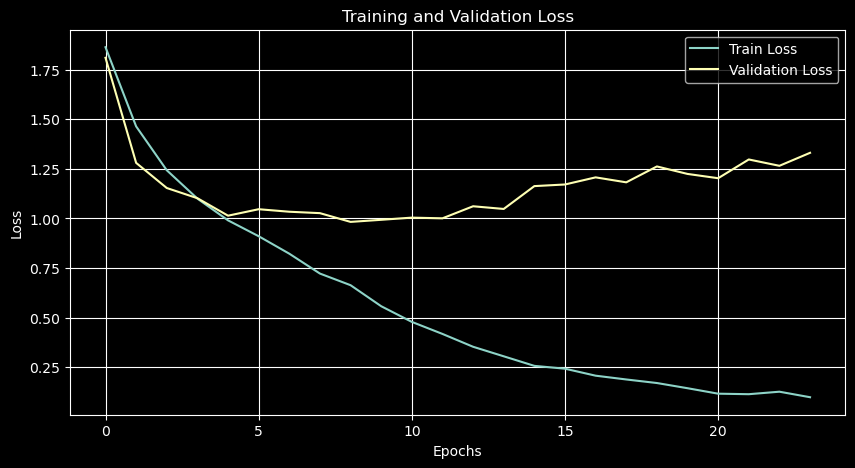

Accuracy: 0.6894

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.77      0.79      0.78       207
           1       0.62      0.79      0.70       189
           2       0.70      0.74      0.72       203
           3       0.68      0.38      0.49       189
           4       0.73      0.77      0.75       201
           5       0.79      0.62      0.69       174
           6       0.72      0.75      0.73       201
           7       0.61      0.69      0.65       163
           8       0.60      0.65      0.62       176
           9       0.69      0.69      0.69       190

    accuracy                           0.69      1893
   macro avg       0.69      0.69      0.68      1893
weighted avg       0.69      0.69      0.68      1893



In [77]:
utils.plot_taining(train_errors_improved, val_errors_improved)
utils.model_calassification_report(model_improved, test_loader, DEVICE, nclasses)